In [1]:
import sys
import joblib

sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Utils.ModelWrapper import ModelWrapper
from Modules.Models.BuildBINNs import AdaMaskBINNCovasim

import Modules.Loaders.DataFormatter as DF
import datetime

from utils import plot_loss_convergence, get_case_name
import matplotlib
#matplotlib.use('Agg')

c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# helper functions
def to_torch(ndarray):
    arr = torch.tensor(ndarray, dtype=torch.float)
    arr.requires_grad_(True)
    arr = arr.to(device)
    return arr

def to_numpy(x):
    return x.detach().cpu().numpy()

Device set to cpu


In [3]:
path = '../Data/covasim_data/drums_data/'
# path = '../Data/covasim_data/xin_data/'

# data parameters
population = int(500e3)
test_prob = 0.1
trace_prob = 0.3
retrain = False
dynamic = True
masking = 3
multiple = True
parallelb = True
n_runs = 64
chi_type = 'piecewise' # constant, piecewise, linear, sin

# model parameters
masking_learned = False
maskb = False

case_name = get_case_name(population, test_prob, trace_prob, True, dynamic=dynamic, chi_type=chi_type)
# yita_lb, yita_ub = 0.2, 0.4

In [4]:
if not maskb and masking_learned: raise Exception("Can not learn masking with masking not included in model.")

In [5]:
if not masking==0:
    if masking==1:
        case_name = case_name + '_maskingdem'
    elif masking==2:
        case_name = case_name + '_maskinguni'
    elif masking==3:
        case_name = case_name + '_maskingnorm'
        
if multiple:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, True, case_name + '_' + str(n_runs), plot=False)
else:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, True, case_name, plot=False)

In [6]:
# split into train/val and convert to torch
# multiple==True and parallelb==False means that data is a list and not normalized
if multiple and not parallelb:
    data = np.mean(params['data'], axis=0)
    data = (data / params['population'])
    if masking > 0:
        avg_masking = np.mean(params['avg_masking'], axis=0)
        avg_masking = (avg_masking / params['population'])
        params['avg_masking'] = avg_masking
# multiple==True and parallelb==True means that the data is a 2d array and normalized
elif multiple and parallelb:
    data = params['data'] # parallel simulations store normalized data
    if masking > 0:
        avg_masking = params['avg_masking']
# otherwise, the data is from a single simulation and is not normalized
else:
    data = params['data']
    data = (data / params['population']).to_numpy()
    if masking > 0:
        avg_masking = params['avg_masking']
        avg_masking = (avg_masking / params['population'])
        params['avg_masking'] = avg_masking
    
params.pop('data')

N = len(data)
t_max = N - 1
t = np.arange(N)

tracing_array = params['tracing_array']

In [7]:
split = int(0.8*N)
p = np.random.permutation(N)

x_train = to_torch(p[:split][:, None]/(N-1))
x_val = to_torch(p[split:][:, None]/(N-1))

if masking_learned:
    all_data = np.concatenate((data, avg_masking[:,None]), axis=1)
    y_train = to_torch(all_data[p[:split]])
    y_val = to_torch(all_data[p[split:]])
else:
    y_train = to_torch(data[p[:split]])
    y_val = to_torch(data[p[split:]])

In [8]:
if masking_learned:
    sparse_coef_path = path + 'mt_eq_coef/'
    if multiple:
        ml_dict = joblib.load(sparse_coef_path + case_name + '_' + str(n_runs) + '_sparse_coef_54comps')
    else:
        ml_dict = joblib.load(sparse_coef_path + case_name + '_sparse_coef_54comps')
    params['mt_coef'] = np.append(np.array(ml_dict['Lasso'].intercept_), ml_dict['Lasso'].coef_)

In [9]:
if masking_learned:
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(2)
    X_mt = poly.fit_transform(data)
    plt.plot(t, np.matmul(X_mt, params['mt_coef']))
    plt.show()

In [10]:
# generate save path
if masking > 0:
    if masking_learned:
        mydir = os.path.join('../models/covasim/mask/learned_masking', datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
    elif maskb:
        mydir = os.path.join('../models/covasim/mask/observed_masking', datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
    else:
        mydir = os.path.join('../models/covasim/mask/no_mask_model', datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
else:
    mydir = os.path.join('../models/covasim/no_mask', datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(mydir)

In [43]:
tau_lb = 0.00
tau_ub = 0.50
eta_deep = True
beta_deep = True
tau_deep = False

In [44]:
# initialize model
binn = AdaMaskBINNCovasim(params, 
                t_max_real=t_max, 
                tracing_array=tracing_array, 
                yita_lb=None, 
                yita_ub=None,
                beta_lb=None,
                beta_ub=None,
                tau_lb=tau_lb,
                tau_ub=tau_ub, 
                chi_type=chi_type,
                eta_deep=eta_deep,
                beta_deep=beta_deep,
                tau_deep=tau_deep,
                maskb=maskb,
                masking_learned=masking_learned)
binn.to(device)

AdaMaskBINNCovasim(
  (surface_fitter): main_MLP(
    (mlp): BuildMLP(
      (activation): ReLU()
      (output_activation): ReLU()
      (MLP): Sequential(
        (0): Linear(in_features=1, out_features=512, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): ReLU()
        (5): Dropout(p=0.2, inplace=False)
        (6): Linear(in_features=256, out_features=256, bias=True)
        (7): ReLU()
        (8): Dropout(p=0.2, inplace=False)
        (9): Linear(in_features=256, out_features=9, bias=True)
        (10): ReLU()
      )
    )
    (softmax): Softmax(dim=1)
  )
  (eta_func): eta_NN(
    (mlp): BuildMLP(
      (activation): ReLU()
      (output_activation): Sigmoid()
      (MLP): Sequential(
        (0): Linear(in_features=3, out_features=256, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)


In [45]:
# compile
parameters = binn.parameters()
opt = torch.optim.Adam(parameters, lr=5e-5)
os.makedirs(os.path.join(mydir, case_name))
model = ModelWrapper(
    model=binn,
    optimizer=opt,
    loss=binn.loss,
    augmentation=None,
    save_name=os.path.join(mydir, case_name) )
if masking_learned:
    model.str_name = 'STEAYDQRFM'
else:
    model.str_name = 'STEAYDQRF'

In [46]:
# save the range information before training
ranges = [binn.yita_lb, binn.yita_ub, binn.beta_lb, binn.beta_ub, binn.tau_lb, binn.tau_ub]
file_name = '_'.join([str(m) for m in ranges])
joblib.dump(None, os.path.join(mydir, file_name)) # model.save_folder
# if retrain
if retrain:
    model.load(model.save_name + '_best_val_model', device=device)
    model.model.train()
    model.save_name += '_retrain'
    
epochs = int(3)
batch_size = 128
rel_save_thresh = 0.05

In [47]:
# train jointly
model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=None,
    verbose=1,
    validation_data=[x_val, y_val],
    early_stopping=int(400e3),
    rel_save_thresh=0.05)

Epoch 2 | Train loss = 1.2680e+06 | Val loss = 1.1028e+06 | Elapsed = 0:00:05             


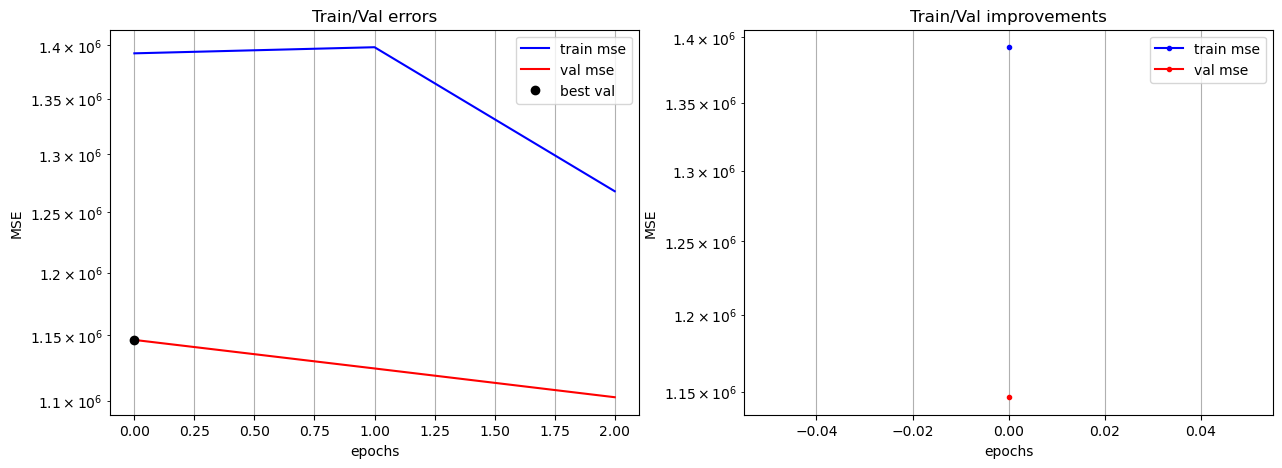

In [48]:
# load training errors
total_train_losses = model.train_loss_list
total_val_losses = model.val_loss_list

plot_loss_convergence(total_train_losses, total_val_losses, rel_save_thresh, model.save_folder)